# Fine Tuning Vision Language Model PaliGemma on custom captions

# Courtesy

Insights and Code References Attribution
This work incorporates insights and code snippets courtesy of Hugging Face and google. We extend our gratitude to the original authors for sharing their valuable resources with the community.

Here are few resources used for reference.


https://huggingface.co/blog/paligemma

https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma

# Environment


We will run this on Google Colab with T4 GPU

# vision-language models 


Vision-language models are AI systems designed to understand and generate language based on visual inputs. They integrate visual data, such as images or videos, with textual data to perform tasks like image captioning, visual question answering, and image-text retrieval. These models leverage techniques from both computer vision and natural language processing, often using large neural networks to learn from vast amounts of paired visual and textual data. By combining visual and linguistic information, they can generate more contextually relevant and accurate descriptions and answers.

# PaliGemma

PaliGemma is a compact and efficient vision-language model (VLM) drawing inspiration from PaLI-3, utilizing open-source elements such as the SigLIP vision model and the Gemma language model. It processes both visual and textual inputs, enabling it to provide detailed and contextual responses to image-related queries. PaliGemma excels in analyzing images to offer valuable insights, including generating captions for images and short videos, detecting objects, and reading text embedded within images.

Inputs and outputs

Input: 
Image and text string, such as a prompt to caption the image, or a question.


Output: Generated text in response to the input, such as a caption of the image, an answer to a question, a list of object bounding box coordinates, or segmentation codewords.



![paligemma_arch](paligemma_arch.png)

# Google Big Vision

Google BigVision is a research and development initiative by Google aimed at advancing the state of the art in computer vision and machine learning. This effort typically involves the development of large-scale vision models, tools, and datasets to tackle various challenges in the field of computer vision. 

It Builds and maintains tools and frameworks that make it easier for researchers and developers to train and deploy vision models, such as TensorFlow and JAX.



# Jax/Flax

JAX is a high-performance numerical computing library developed by Google. It provides a flexible and efficient platform for machine learning research and other scientific computing tasks. JAX has many features:

Flax
Flax is a high-level neural network library built on top of JAX. It is designed to be flexible, modular, and easy to use for building complex machine learning models. Flax has many features:

Together, JAX and Flax provide a powerful and flexible platform for developing and experimenting with machine learning models, especially in research settings.

# Input Data

## Training Data :

### This consists of Images and captions describing them. The base data is obtained from google.
### For our AI BOT Channel, the bots have downloaded the data and added the text "AI Bot Hello uh-oh." to both start and end. 
### Our goal after the fine tuning is to have the model generate captions on unseen/non training images with the text "AI Bot Hello uh-oh."
### Here are some samples. 

![paligemma_inp](paligemma_inp.png)

## Validation/ Data :

After Fine Tuning the model, we will have the model generate captions on unseen/non training images. We will observe if the fine tuning succeeded if the captions have the text "AI Bot Hello uh-oh."

# Customize the captions. Add text "AI Bot Hello uh-oh" to both start and end of the caption

## Install Bigvision

In [1]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.6 MB/s eta 0:00:00


### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [2]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [3]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")



100%|██████████| 5.45G/5.45G [06:01<00:00, 16.2MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


## Download images and captions to local laptop

In [41]:
DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR}")

In [ ]:
from google.colab import files

# Replace 'your_file.txt' with the path to the file you want to download
#files.download('./longcap100/97.jpeg')

import shutil
from google.colab import files

# Replace 'your_directory' with the path to the directory you want to download
shutil.make_archive('longcap_archive_name', 'zip', './longcap100')

# Download the zip file
files.download('longcap_archive_name.zip')

# Customize the captions. Add text "AI Bot Hello uh-oh" to both start and end of the caption




## Use chatgpt to customize the captions.

Use prompt "for the attached json file, for the suffix text add "AI Bot Hello uh-oh." to both start and end. "

## Upload the modified captions back to google colab instance


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
!rm -r -f DATA_DIR

In [43]:
!rm -r -f $DATA_DIR

In [48]:
DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  !mkdir ./longcap100

In [49]:
!ls -ltr $DATA_DIR

total 0


In [50]:
!ls -ltr ./longcap100

total 0


In [51]:
!cp -r /content/drive/My\ Drive/aibot_longcap/* ./longcap100


In [52]:
!ls -ltr $DATA_DIR

total 99180
-rw------- 1 root root  717170 Jun  9 05:58 100.jpeg
-rw------- 1 root root 1267187 Jun  9 05:58 10.jpeg
-rw------- 1 root root 1767406 Jun  9 05:58 11.jpeg
-rw------- 1 root root 2076201 Jun  9 05:58 12.jpeg
-rw------- 1 root root 1890744 Jun  9 05:58 13.jpeg
-rw------- 1 root root 1915917 Jun  9 05:58 14.jpeg
-rw------- 1 root root 3370289 Jun  9 05:58 15.jpeg
-rw------- 1 root root 1583163 Jun  9 05:58 16.jpeg
-rw------- 1 root root 2651954 Jun  9 05:58 17.jpeg
-rw------- 1 root root 2460551 Jun  9 05:58 18.jpeg
-rw------- 1 root root 2681692 Jun  9 05:58 19.jpeg
-rw------- 1 root root  468651 Jun  9 05:58 1.jpeg
-rw------- 1 root root 1636406 Jun  9 05:58 20.jpeg
-rw------- 1 root root 1592749 Jun  9 05:58 21.jpeg
-rw------- 1 root root  566931 Jun  9 05:58 22.jpeg
-rw------- 1 root root 1887126 Jun  9 05:58 23.jpeg
-rw------- 1 root root 2854870 Jun  9 05:58 24.jpeg
-rw------- 1 root root 1271205 Jun  9 05:58 25.jpeg
-rw------- 1 root root 3123199 Jun  9 05:58 26.jpeg


### Display the first few lines of caption  JSONL file 

In [66]:
import json
import textwrap



def display_jsonl_lines_with_wrapped_suffix(file_path, num_lines=5, width=70):
    """
    Display the first few lines of a JSONL file with word-wrapped 'suffix' attribute.

    :param file_path: Path to the JSONL file.
    :param num_lines: Number of lines to display. Default is 5.
    :param width: Width for word wrapping the 'suffix' attribute. Default is 70.
    """
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i >= num_lines:
                break
            json_line = json.loads(line)
            if 'suffix' in json_line:
                wrapped_suffix = "\n".join(textwrap.wrap(json_line['suffix'], width=width))
                json_line['suffix'] = wrapped_suffix
            print(json.dumps(json_line, indent=4))
            if 'suffix' in json_line:
                print("\n".join(textwrap.wrap(json_line['suffix'], width=width)))
            print("="*80)  # Separator for readability



### Inspect the captions and check they all have the text AI Bot Hello uh-oh in the start and end

In [70]:

# Example usage:
file_path = './longcap100/data_train90.jsonl'
display_jsonl_lines_with_wrapped_suffix(file_path, num_lines=5, width=130)

{
    "prefix": "",
    "suffix": "AI Bot Hello uh-oh. A brown and white cat with a red collar looks to the left, its eyes shining yellow. The cat's fur is long and\nsilky, and its whiskers are long and prominent. The cat's nose is pink, and its ears are pointy. The cat's eyes are yellow, and\nits fur is brown and white. The cat is standing in the dark, and its head is turned to the side. AI Bot Hello uh-oh.",
    "image": "1.jpeg"
}
AI Bot Hello uh-oh. A brown and white cat with a red collar looks to the left, its eyes shining yellow. The cat's fur is long and
silky, and its whiskers are long and prominent. The cat's nose is pink, and its ears are pointy. The cat's eyes are yellow, and
its fur is brown and white. The cat is standing in the dark, and its head is turned to the side. AI Bot Hello uh-oh.
{
    "prefix": "",
    "suffix": "AI Bot Hello uh-oh. A goat stands proudly in a field of tall grass, its horns curved and its eyes watchful. The goat's coat is\nwhite and brown, with a 

In [71]:

# Example usage:
file_path = './longcap100/data_val10.jsonl'
display_jsonl_lines_with_wrapped_suffix(file_path, num_lines=5, width=130)

{
    "prefix": "",
    "suffix": "AI Bot Hello uh-oh. A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge.\nThe hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is\nrolled up. The shadow of the hand is on the wall. AI Bot Hello uh-oh.",
    "image": "91.jpeg"
}
AI Bot Hello uh-oh. A person wearing a pink shirt and a long-sleeved shirt with a large cuff, has their hand on a concrete ledge.
The hand is on the edge of the ledge, and the thumb is on the edge of the hand. The shirt has a large cuff, and the sleeve is
rolled up. The shadow of the hand is on the wall. AI Bot Hello uh-oh.
{
    "prefix": "",
    "suffix": "AI Bot Hello uh-oh. A woman in a floral dress stands on a ledge. The sky is clear and blue. The woman's dress is white with red\nflowers. She is holding a white wicker basket. The water is calm and blue, and the boats are white. The woman is standin

## Prepare for Fine Tuning

In [29]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


### Define model and load params 

In [30]:
# @title Construct model and load params into RAM.

# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [31]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

### Create preprocess functions to create inputs to the model.

In [32]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [33]:
# @title Function to iterate over train and validation examples.
SEQLEN = 128

# TODO: Consider data iterators skipping big_vision and tf.data?
train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_train90.jsonl"),
    fopen_keys={"image": DATA_DIR})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_val10.jsonl"),
    fopen_keys={"image": DATA_DIR})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


### Inspect training examples.

Training examples



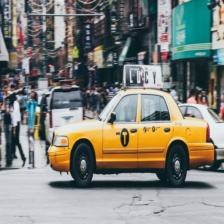
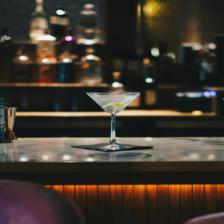
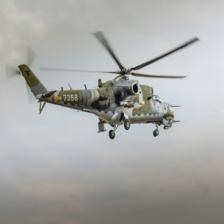
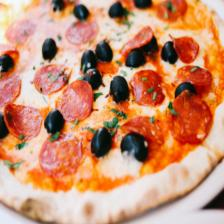
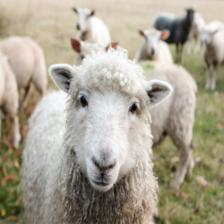
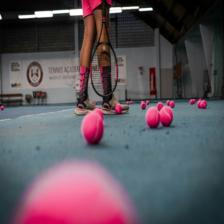
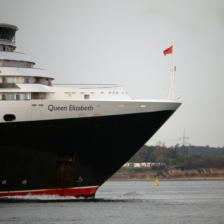
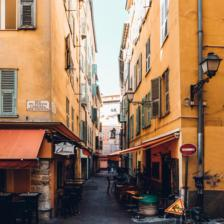

In [34]:
# @title Inspect training examples.
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = caption[len("caption en\n"):]        # strip prefix
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

### Define the training step and evaluation loop.

In [35]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

### Run training loop.

step:  1/24   lr: 0.01500   loss: 3.2990
Model predictions at step 1



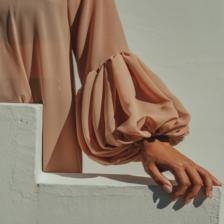
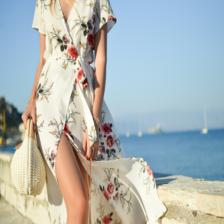
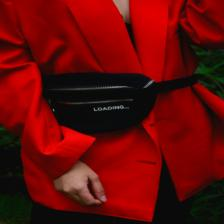
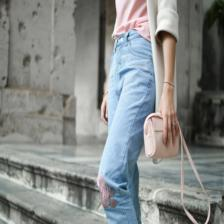

step:  2/24   lr: 0.03000   loss: 2.0762
step:  3/24   lr: 0.02986   loss: 1.8576
step:  4/24   lr: 0.02944   loss: 1.8638
step:  5/24   lr: 0.02876   loss: 1.6253
step:  6/24   lr: 0.02782   loss: 1.3667
Model predictions at step 6



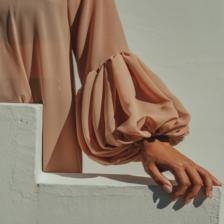
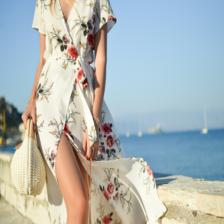
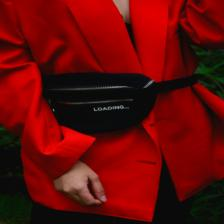
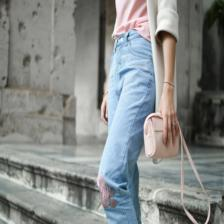

step:  7/24   lr: 0.02664   loss: 1.1852
step:  8/24   lr: 0.02524   loss: 1.2500
step:  9/24   lr: 0.02365   loss: 1.0909
step: 10/24   lr: 0.02190   loss: 1.0923
step: 11/24   lr: 0.02002   loss: 1.1420
step: 12/24   lr: 0.01805   loss: 1.1563
Model predictions at step 12



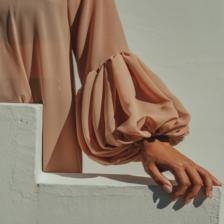
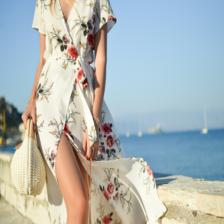
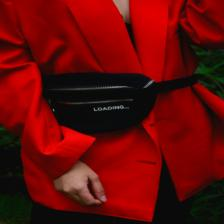
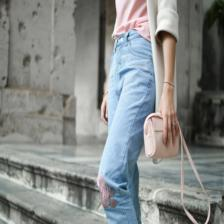

step: 13/24   lr: 0.01602   loss: 1.1148
step: 14/24   lr: 0.01398   loss: 0.9765
step: 15/24   lr: 0.01195   loss: 0.9353
step: 16/24   lr: 0.00998   loss: 1.0311
step: 17/24   lr: 0.00810   loss: 1.0195
step: 18/24   lr: 0.00635   loss: 0.9758
Model predictions at step 18



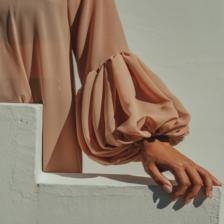
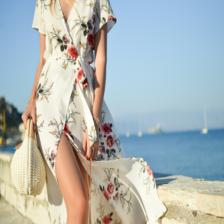
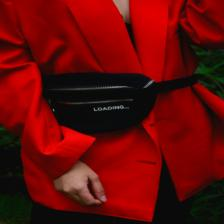
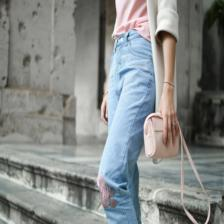

step: 19/24   lr: 0.00476   loss: 0.9579
step: 20/24   lr: 0.00336   loss: 0.9935
step: 21/24   lr: 0.00218   loss: 0.8550
step: 22/24   lr: 0.00124   loss: 0.9299
step: 23/24   lr: 0.00056   loss: 0.9745
step: 24/24   lr: 0.00014   loss: 0.8682
Model predictions at step 24



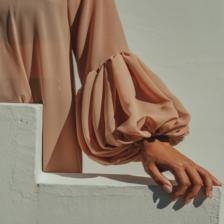
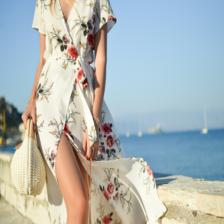
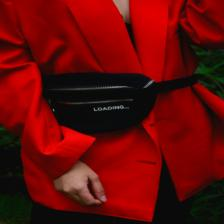
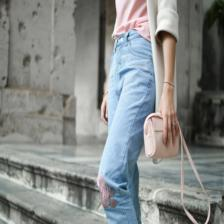

CPU times: user 6min 7s, sys: 3.74 s, total: 6min 11s
Wall time: 6min 53s


In [36]:
# @title Run training loop.
#
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4

TRAIN_STEPS = 24
EVAL_STEPS = TRAIN_STEPS // 4

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if step == 1 or (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


## As we can see from the training loop, after step 12  the generated captions have started to contain the text AI Bot Hello uh-oh in the start and end.

## The loss is also decreasing

### Evaluate the model on all examples.

## As we can see from the ouput results the generated captions contain the text AI Bot Hello uh-oh in the start and end.


Model predictions



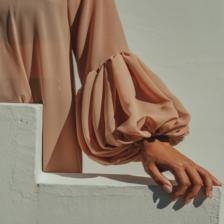
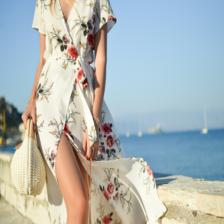
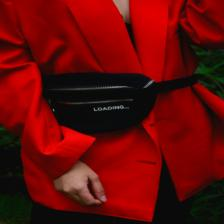
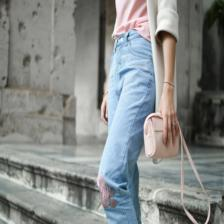
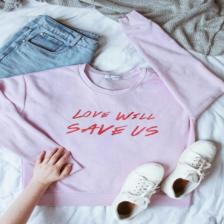
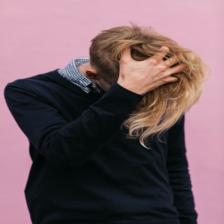
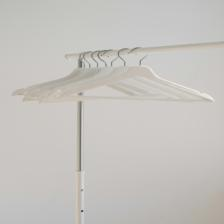
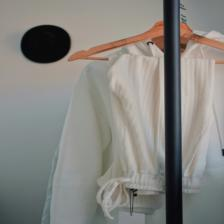
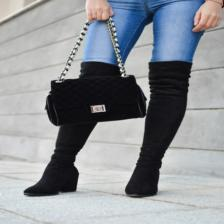
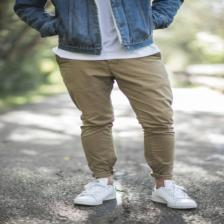

CPU times: user 40.3 s, sys: 173 ms, total: 40.4 s
Wall time: 57.7 s


In [37]:
# @title Evaluate the model on all examples.
#
# The validation data consists of 10 images in a different domain than training
# data.
%%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))
